# SDTSIA210 Machine Learning - Regression Project

## Boston Housing Data

## Doriand Petit - Priam Cardouat - David Gérard

In [1]:
#Imports Required
import cv2
import numpy as np
from time import time
import pandas as pd
import os

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
np.random.seed(seed=666)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras import optimizers
print(tf.keras.__version__)

2.4.0


The Boston Housing dataset gives information collected by the U.S Census Service concerning housing in the area of Boston Mass. According to the website, it has two prototasks: nox, in which the nitrous oxide level is to be predicted; and price, in which the median value of a home is to be predicted. I will begin with some general remarks and preprocessings on the dataset. Then, I will try to solve the first prototask, by creating a bunch of different models to predict a regression on. Finally, I will  use the functions created to solve the second prototask.

### The Boston Housing Dataset - General Information and Preprocessing

First of all, let's transform the initial SQL file into a proper pandas data frame. In order to do this, I will gradually change the SQL file into txt files that can be easily read by the pandas library.

In [2]:
def transform_file(file_path) :
    """
    Transform the SQL file into a txt file with appropriate format for the pandas library
    Input : file_path, the complete file path to the sql file (including the name of the file)
    Output : the pandas dataframe
    
    """
    with open(file_path) as f, open("boston.txt",'w') as f1 :
        k = 0
        for line in f :
            if k > 21 :   # The 21 first lines are a description of the data
                f1.write(line)
            k+=1
    
    k=2
    with open("boston.txt") as f1, open("boston2.txt",'w') as f2:
        f2.write("CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV\n")
        for line in f1 :
            if k%2 == 0 :
                l = line
                l=l.rstrip()     # We need to put each row of data into one line, which is not the case in the sql file
            else :
                l = l+line
                f2.write(str(l[1:]))
                l=""
            k+=1
    c="a"
    with open("boston2.txt",'r') as f2, open("boston3.txt",'w') as f3 :
        for line in f2 :
            for char in line :
                if char ==" " and c!= " ":
                    f3.write(",")    # Because each number is not separated by the same number of space characters, I add commas
                elif char != " " :
                    f3.write(char)
                c = char
    return(pd.read_csv("boston3.txt",sep=","))

In [3]:
df = transform_file("boston.sql")
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


As we can see, the data set contains 14 different features for 506 samples. Here are the list of the features :

<ul>

 <li>CRIM  :   per capita crime rate by town </li>
 <li>ZN    :   proportion of residential land zoned for lots over 25,000 sq.ft. </li>
 <li>INDUS  :  proportion of non-retail business acres per town </li>
 <li>CHAS  :   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) </li>
 <li>NOX   :   nitric oxides concentration (parts per 10 million) </li>
 <li>RM    :   average number of rooms per dwelling </li>
 <li>AGE   :   proportion of owner-occupied units built prior to 1940 </li>
 <li>DIS   :   weighted distances to five Boston employment centres </li>
 <li>RAD   :   index of accessibility to radial highways </li>
 <li>TAX   :   full-value property-tax rate per 10,000 dollars</li>
 <li>PTRATIO :  pupil-teacher ratio by town </li>
 <li>B     :   $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town </li>
 <li>LSTAT :   % lower status of the population </li>
 <li>MEDV  :   Median value of owner-occupied homes in 1000's dollars </li>
    
</ul>


Note : the lower status corresponds to the average of adults without some high school education and of male workers classified as laborers


In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.716290,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,2.653510,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.250895,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,2.326717,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,9.966540,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


This previous table gives some general information on each features. In order to have a better understanding of each feature, here are the histogram of each one. 

An interesting thing to notice is that the features are really different one from another. Some have gaussians distributions (RM for instance), others are heavily represented on only one bar (ZN), and there is even the CHAS variable that is a dummy variable.

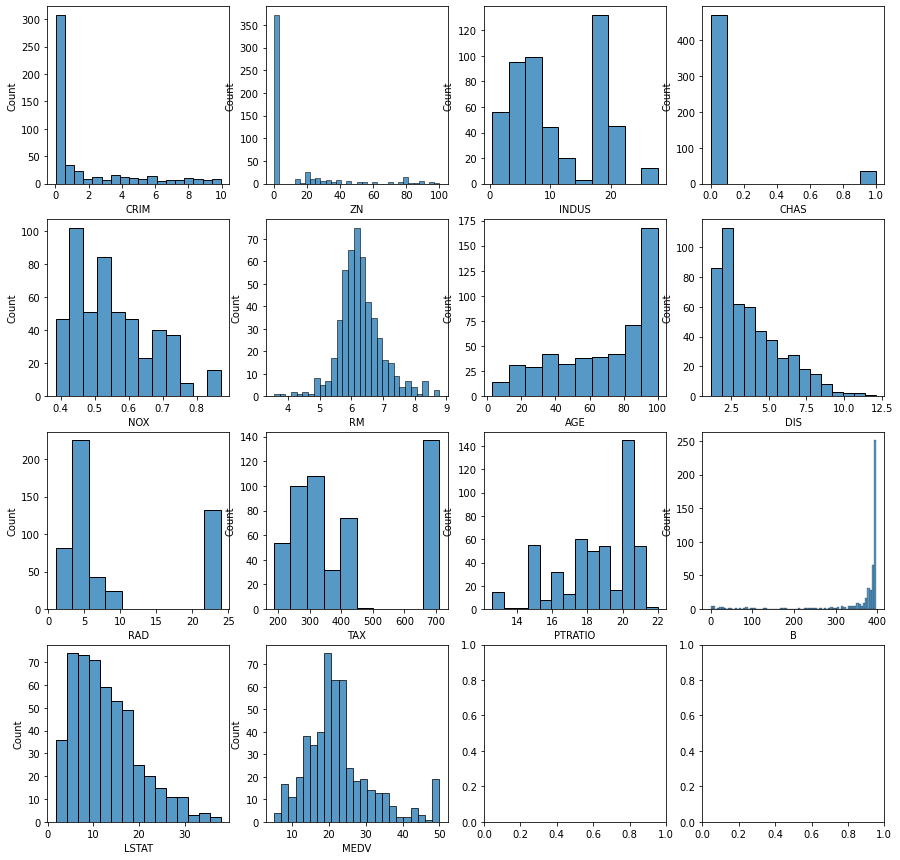

In [5]:
fig, axes = plt.subplots(ncols=4, nrows=4,figsize=(15,15))

for i, ax in zip(range(14), axes.flat):
    sns.histplot(df[df.columns[i]], ax=ax)
plt.show()

Another interesting information we can get from the dataset is its correlation matrix that shows how each feature is correlated to the others. The further away the correlation coefficient is from zero, the stronger the relationship between the two variables.

From the map drawn below, we can first of all notice that the CHAS variable (which indicates if the space borders the river) seems really uncorrelated to the other variables, as the coefficients seem to vary between approximately -0.1 and 0.1. This is quite logical as the other features don't have a lot to do with the presence of the river (for instance the pupil-teacher ratio or the number of room per dwellings.

On the contrary, we can also find some features couples that have an important correlation. Some of them are actually quite logical. For instance, the LSTAT and the MEDV have a coefficient really close to -1 and we can easily imagine that the value of the house is lower if the neighborhood is poor. Other features couples can seem a bit more random, with for instace the near linearity between the tax rate and crime rate.  


<AxesSubplot:>

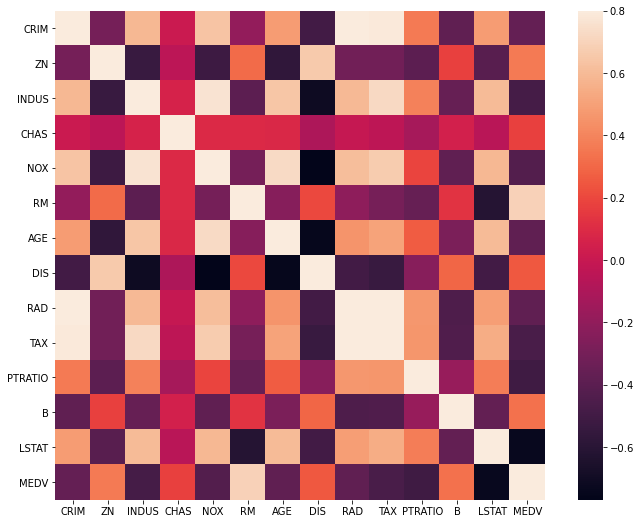

In [6]:
corrmap = df .corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmap, vmax=.8, square=True)

Before doing any other computations, it is always important to check if the dataset has missing values. The following command shows that this is not the case with our dataset.

In [7]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now that we understand the dataset, let's begin the preprocessing of the data. First of all, let's create the training dataset and the testing dataset. Because we will have different class to predict I created a function to create these sets according to our prototask.

In [8]:
def create_XY(name) :
    df = pd.read_csv("boston3.txt",sep=",")
    Y = df.pop(name)
    X = df
    df = pd.read_csv("boston3.txt",sep=",")
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=0)
    return (X,Y,X_train,X_test,Y_train,Y_test)


In [9]:
X,Y,X_train,X_test,Y_train,Y_test=create_XY('NOX')

Whether it is a classification or a regression problem, there is a preprocessing method that is almost always necessary : scaling the data. Because all of my features have positive values, I used a MinMax normalization (keeping the data between 0 and 1) rather than a Standard standardization. 

It is also interesting to notice that the use of the MinMaxScaler is compatible with the CHAS variable (which is the dummy variable) as this scaler will not change his values.

In [10]:
## Normalization
norm = MinMaxScaler()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

### Regression on the Nitric Oxides Concentration

We are going to predic the Nitric Oxides Concentration. This indicator serves as indicator for pollution in the different areas and we will thus also try to understand what are the causes of the pollution there.

First of all, we are going to test four really classic models for the regression problem : the ordinary least squares (Linear Regression) estimator, the ridge one, the lasso one and finally the one that combines these models called ElasticNet. 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

def ols_ridge_lasso(X_train,Y_train,X_test,Y_test) :
    """
    
    Compute OLS,Ridge,Lasso and ElasticNet models and compute the scores and L1 error of the prediction
    
    """
    x_axis = np.arange(len(Y_test))
    print("##### OLS #####")
    model_ols = LinearRegression()
    model_ols.fit(X_train,Y_train)
    Y_pred = model_ols.predict(X_test)
    print("Score : ",model_ols.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    # Sort the true data and its prediction accordingly :
    Y_data_0 = [Y_test,Y_pred]
    Y_data_0 = sorted(np.transpose(Y_data_0),key=lambda x: x[0])
    Y_data_0 = np.transpose(Y_data_0)
    
    print("##### Ridge #####")
    model = Ridge()
    parameters={'alpha':np.logspace(-3, 3, num=50)}
    cv = GridSearchCV(model,parameters)
    cv.fit(X_train,Y_train)
    print(cv.best_params_)
    Y_pred=cv.predict(X_test)
    print("Score : ",cv.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    Y_data_1 = [Y_test,Y_pred]
    Y_data_1 = sorted(np.transpose(Y_data_1),key=lambda x: x[0])
    Y_data_1 = np.transpose(Y_data_1)
    
    print("##### Lasso #####")
    model = Lasso()
    parameters={'alpha':np.logspace(-3, 3, num=50)}
    cv = GridSearchCV(model,parameters)
    cv.fit(X_train,Y_train)
    print(cv.best_params_)
    Y_pred=cv.predict(X_test)
    print("Score : ",cv.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    Y_data_2 = [Y_test,Y_pred]
    Y_data_2 = sorted(np.transpose(Y_data_2),key=lambda x: x[0])
    Y_data_2 = np.transpose(Y_data_2)
    
    print("##### ElasticNet #####")
    model = ElasticNet()
    parameters={'alpha':np.logspace(-3, 3, num=50),'l1_ratio':np.arange(0.001,1,999)}
    cv = GridSearchCV(model,parameters)
    cv.fit(X_train,Y_train)
    print(cv.best_params_)
    Y_pred=cv.predict(X_test)   
    print("Score : ",cv.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    Y_data_3 = [Y_test,Y_pred]
    Y_data_3 = sorted(np.transpose(Y_data_3),key=lambda x: x[0])
    Y_data_3 = np.transpose(Y_data_3)
    
    fig, axs = plt.subplots(1, 4,figsize=(30, 6))
    axs[0].set_title("OLS")
    axs[0].scatter(x_axis,Y_data_0[0],c='r',label="True Data")
    axs[0].scatter(x_axis,Y_data_0[1],label="Predicted Data")
    axs[1].set_title("Ridge")
    axs[1].scatter(x_axis,Y_data_1[0],c='r',label="True Data")
    axs[1].scatter(x_axis,Y_data_1[1],label="Predicted Data")
    axs[2].set_title("Lasso")
    axs[2].scatter(x_axis,Y_data_2[0],c='r',label="True Data")
    axs[2].scatter(x_axis,Y_data_2[1],label="Predicted Data")
    axs[3].set_title("Elasticnet")
    axs[3].scatter(x_axis,Y_data_3[0],c='r',label="True Data")
    axs[3].scatter(x_axis,Y_data_3[1],label="Predicted Data")
    axs[0].legend(loc="upper left")
    axs[1].legend(loc="upper left")
    axs[2].legend(loc="upper left")
    axs[3].legend(loc="upper left")

##### OLS #####
Score :  0.7406198952612091
Score 2 :  0.04469039437175199
##### Ridge #####
{'alpha': 1.5264179671752334}
Score :  0.7313537072176077
Score 2 :  0.04479308494481474
##### Lasso #####
{'alpha': 0.001}
Score :  0.7200448164547515
Score 2 :  0.04452921672801304
##### ElasticNet #####
{'alpha': 0.005428675439323859, 'l1_ratio': 0.001}
Score :  0.7284938741706392
Score 2 :  0.04490097963320685


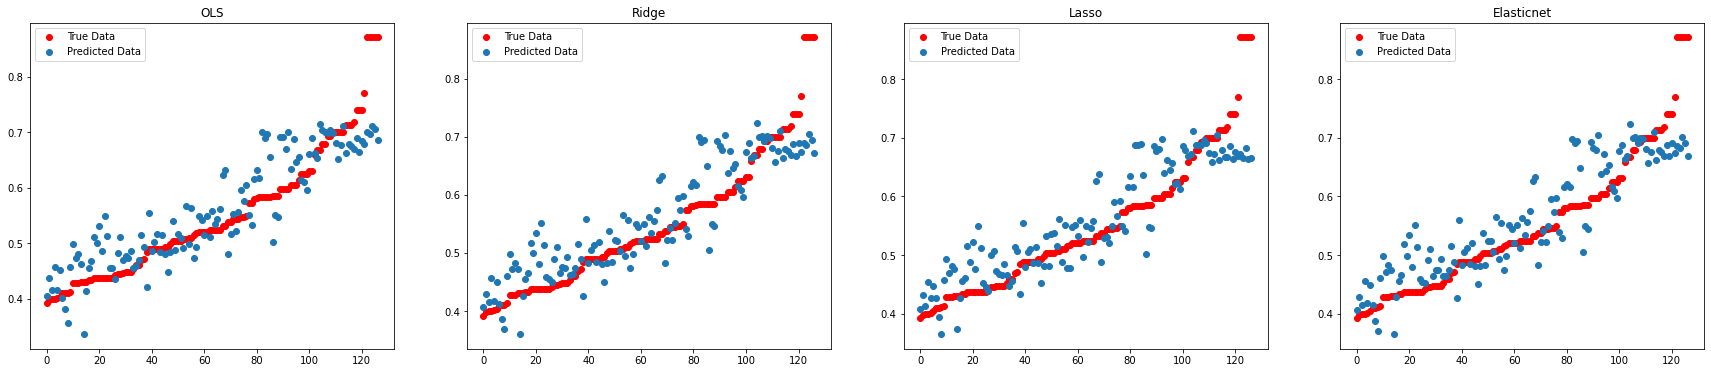

In [12]:
ols_ridge_lasso(X_train,Y_train,X_test,Y_test)


Note : In order to have a better graphical representation of our results, I sorted the true values of Y_test and used the same sorted order on Y_pred.

First of all, every model has been created via cross validation in order to have the most optimal models that will give the best predictions.

All these models give relatively equivalent $R^2$ results (approximately 0.73, out of 1), which are not that bad actually. However, the graphs above easily show that, while most of the predicted values are around the true value, the models are far from being perfect. Another important score to look at is the error, which is the L1 (mean absolute error) one here. It will be quite interesting to compare it with the following models.

We can also notice that for all of these models, the predicted values are quite close one from another with similar patterns. This is actually normal because the definition of these models all have the OLS estimator as a base and will have similar predictions.

Finally, we can notice that the few last samples that have a way higher value than the other samples cannot be predicted with these models, they are not robust to abrupt changes, which is a problem here.

Now, let's check what were the most important features for the fitting of the Linear Regression model.


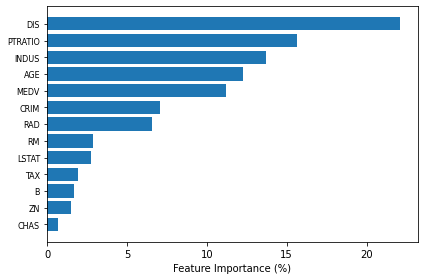

In [13]:
def ols_feature_importance(X_train,Y_train):
    """
    Plot the feature imoportance in the OLS model
    
    """
    model_ols = LinearRegression()
    model_ols.fit(X_train,Y_train)

    feature_importance = abs(model_ols.coef_)
    feature_importance = 100.0 * (feature_importance / feature_importance.sum())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0])

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(pd.DataFrame(X).columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Feature Importance (%)')
    plt.tight_layout()   
    plt.show()

ols_feature_importance(X_train,Y_train)

First of all, we can notice that the distance to the employment center is the most important feature to predict our values of pollution. While this seems understandable that the two variables are linked, the fact that it is that important is a bit surprising, as for instace the proportion of non-retail businesses (industries) is approximatively 10% less important.

Another thing much more surprising is that the second feature most important is the pupil teacher ratio that seems to have little to do with pollution. We can maybe try to link the two variables by saying that the ratio shows the poverty of the neighborhood, which then can be linked to the pollution, but all of this might be overthought. 

A possible explanation to why did some of these feature importances seem that random was simply that the models are not perfect at all, it is then interesting to look at better models and other feature importances. Now we will try to use a few other models that are a bit more complicated than the previous ones : K-Nearest Neighbors, Support Vector Regressor and Random Forest.

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

def knn_svr_randforest(X_train,Y_train,X_test,Y_test) :
    """
    
    Compute KNN, Support Vector Regression and Random Forest models and compute the scores and L1 error of the prediction
    
    """
    x_axis = np.arange(len(Y_test))
    print("##### KNN #####")
    knn = KNeighborsRegressor()
    parameters={'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11],'weights':['uniform','distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
    clf = GridSearchCV(knn,parameters)
    clf.fit(X_train,Y_train)
    print(clf.best_params_)
    Y_pred=clf.predict(X_test)
    print("Score : ",clf.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    # Sort the true data and its prediction accordingly :
    Y_data_0 = [Y_test,Y_pred]
    Y_data_0 = sorted(np.transpose(Y_data_0),key=lambda x: x[0])
    Y_data_0 = np.transpose(Y_data_0)
    
    print("##### SVR #####")
    svm = SVR(kernel='rbf')
    parameters = {'C':[0.01,0.1,1,10,100,1000,10000],'gamma':[0.001,0.01,0.1,1,10,100,1000,'scale','auto']}
    cv = GridSearchCV(svm,parameters)
    cv.fit(X_train,Y_train)
    print(cv.best_params_)
    Y_pred=cv.predict(X_test)
    print("Score : ",cv.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    Y_data_1 = [Y_test,Y_pred]
    Y_data_1 = sorted(np.transpose(Y_data_1),key=lambda x: x[0])
    Y_data_1 = np.transpose(Y_data_1)
    
    print("##### Random Forest #####")
    #Note : Because the cross validation is quite long to compute, I've done the more complete one before and just compute 
    #there the optimal n_estimators.
    forest = RandomForestRegressor(criterion='mae',min_samples_split = 2, max_features='sqrt',min_samples_leaf=1)
    parameters = {'n_estimators':np.logspace(0, 3, num=20,dtype=int),
    }
    cv_forest = GridSearchCV(forest,parameters)
    cv_forest.fit(X_train,Y_train)
    print(cv_forest.best_params_)
    Y_pred=cv_forest.predict(X_test)
    print("Score : ",cv_forest.score(X_test,Y_test))
    print("Score 2 : ", mean_absolute_error(Y_test,Y_pred))
    Y_data_2 = [Y_test,Y_pred]
    Y_data_2 = sorted(np.transpose(Y_data_2),key=lambda x: x[0])
    Y_data_2 = np.transpose(Y_data_2)
    
    fig, axs = plt.subplots(1, 3,figsize=(30, 6))
    axs[0].set_title("KNN")
    axs[0].scatter(x_axis,Y_data_0[0],c='r',label="True Data")
    axs[0].scatter(x_axis,Y_data_0[1],label="Predicted Data")
    axs[1].set_title("SVR")
    axs[1].scatter(x_axis,Y_data_1[0],c='r',label="True Data")
    axs[1].scatter(x_axis,Y_data_1[1],label="Predicted Data")
    axs[2].set_title("Random Forest")
    axs[2].scatter(x_axis,Y_data_2[0],c='r',label="True Data")
    axs[2].scatter(x_axis,Y_data_2[1],label="Predicted Data")

    axs[0].legend(loc="upper left")
    axs[1].legend(loc="upper left")
    axs[2].legend(loc="upper left")


##### KNN #####
{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Score :  0.8186839859648727
Score 2 :  0.028288447852597706
##### SVR #####
{'C': 1, 'gamma': 0.1}
Score :  0.7350770270385771
Score 2 :  0.04842265553039609
##### Random Forest #####
{'n_estimators': 37}
Score :  0.8806594729995957
Score 2 :  0.025080591615237274


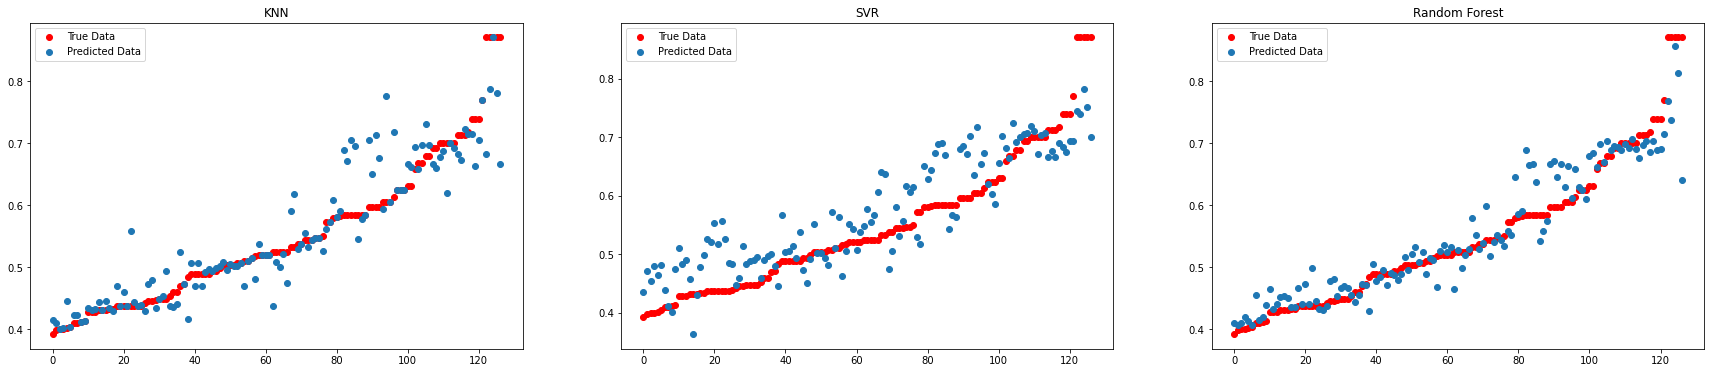

In [15]:
knn_svr_randforest(X_train,Y_train,X_test,Y_test)

While the results of the support vector regressor are relatively similar to the previous algorithms (similar scores, but predicted values totally different), the two other methods gives way better results. 

For these two models, there are way more really precise predictions. While the other models don't have a lot of important outliers but are rarely accurately predicting the good value, the KNN model and the random forest one are way more precise, and most of the loss and the accuracy are contained in outliers. This is particularly the case for KNN, as the outliers are even further from the true value than in the random forest model.

We can also notice that for these two models, some of the highest value are actually predicted in contrary of the first models. However, this zone still is problematic for the prediction.

Let's look at the feature importance of the random forest model to compare it with the OLS one.

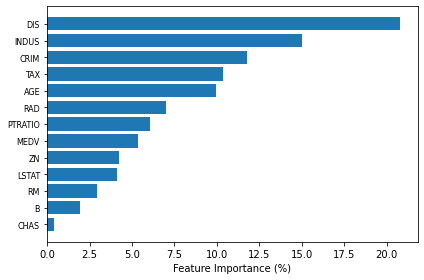

In [16]:
def random_forest_importance(X_train,Y_train) :
    """
    Plot the feature importance on the previously computed optimal random forest model.
    
    """
    forest = RandomForestRegressor(criterion='mae',min_samples_split = 2, max_features='sqrt',min_samples_leaf=1,n_estimators=233)
    forest.fit(X_train,Y_train)
    feature_importance = forest.feature_importances_
    feature_importance = 100.0 * (feature_importance)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0])
    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(pd.DataFrame(X).columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Feature Importance (%)')
    plt.tight_layout()   
    plt.show()
    
random_forest_importance(X_train,Y_train)

First of all, we can see that the distance feature is still the most important feature to predict the values in this better model. The percentage is even quite similar. 

However, the rest of the list had some changes. The pupil teacher ratio that was surprisingly important in the OLS model is now ranked 7 out of 13. The fact that the presence of industries and the distance to employment centers are the most important can be easily linked to the pollution. The rest of the ranking can be surprising. However, most of these other features can't be directly linked to pollution (apart probably from the proximity to highway, and even this one is not as linkable as the first two ones). Hence, it is more complex to compare their feature importance on the level of pollution.

After trying all these algorithms, the next step is now to try to fit a neural network to predict our data. Due to our kind of data and kind of problem, we will create a multi-layer perceptron with a linear output. Here is the architecture I used :

In [17]:
model = Sequential()
#input layer
model.add(Dense(13, input_shape=(13,)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# hidden layers
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
    
model.add(Dense(64))
model.add(Activation("relu"))
    
# output layer
model.add(Dense(1, activation='linear'))

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.mean_absolute_error)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
activation (Activation)      (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

The model is relatively easy and uses two hidden layers. At first, I used only one hidden layer but the results were better with two hidden layers. I also added two more original layers : some BatchNormalization, as well as some Dropout respectively to normalize the input of each layer and to avoid overfitting. Moreover, I chosed to work with some squared L2 loss (that is easier to interpret than the original L2 loss).

In [18]:
history = model.fit(x=X_train, y=Y_train, batch_size=40, epochs=1000,verbose=2,validation_data=(X_test, Y_test)) 

Epoch 1/1000
10/10 - 1s - loss: 0.4053 - val_loss: 0.3410
Epoch 2/1000
10/10 - 0s - loss: 0.3169 - val_loss: 0.4217
Epoch 3/1000
10/10 - 0s - loss: 0.2593 - val_loss: 0.4254
Epoch 4/1000
10/10 - 0s - loss: 0.2208 - val_loss: 0.4167
Epoch 5/1000
10/10 - 0s - loss: 0.2138 - val_loss: 0.4375
Epoch 6/1000
10/10 - 0s - loss: 0.1903 - val_loss: 0.3915
Epoch 7/1000
10/10 - 0s - loss: 0.1833 - val_loss: 0.4090
Epoch 8/1000
10/10 - 0s - loss: 0.1693 - val_loss: 0.3668
Epoch 9/1000
10/10 - 0s - loss: 0.1708 - val_loss: 0.3425
Epoch 10/1000
10/10 - 0s - loss: 0.1372 - val_loss: 0.3337
Epoch 11/1000
10/10 - 0s - loss: 0.1430 - val_loss: 0.3110
Epoch 12/1000
10/10 - 0s - loss: 0.1446 - val_loss: 0.3141
Epoch 13/1000
10/10 - 0s - loss: 0.1272 - val_loss: 0.2843
Epoch 14/1000
10/10 - 0s - loss: 0.1277 - val_loss: 0.2805
Epoch 15/1000
10/10 - 0s - loss: 0.1242 - val_loss: 0.2529
Epoch 16/1000
10/10 - 0s - loss: 0.1177 - val_loss: 0.2569
Epoch 17/1000
10/10 - 0s - loss: 0.1223 - val_loss: 0.2399
Epoch 

Epoch 140/1000
10/10 - 0s - loss: 0.0371 - val_loss: 0.0348
Epoch 141/1000
10/10 - 0s - loss: 0.0430 - val_loss: 0.0347
Epoch 142/1000
10/10 - 0s - loss: 0.0398 - val_loss: 0.0348
Epoch 143/1000
10/10 - 0s - loss: 0.0413 - val_loss: 0.0383
Epoch 144/1000
10/10 - 0s - loss: 0.0385 - val_loss: 0.0358
Epoch 145/1000
10/10 - 0s - loss: 0.0409 - val_loss: 0.0381
Epoch 146/1000
10/10 - 0s - loss: 0.0407 - val_loss: 0.0371
Epoch 147/1000
10/10 - 0s - loss: 0.0389 - val_loss: 0.0445
Epoch 148/1000
10/10 - 0s - loss: 0.0417 - val_loss: 0.0407
Epoch 149/1000
10/10 - 0s - loss: 0.0379 - val_loss: 0.0351
Epoch 150/1000
10/10 - 0s - loss: 0.0429 - val_loss: 0.0359
Epoch 151/1000
10/10 - 0s - loss: 0.0433 - val_loss: 0.0413
Epoch 152/1000
10/10 - 0s - loss: 0.0384 - val_loss: 0.0471
Epoch 153/1000
10/10 - 0s - loss: 0.0431 - val_loss: 0.0375
Epoch 154/1000
10/10 - 0s - loss: 0.0408 - val_loss: 0.0381
Epoch 155/1000
10/10 - 0s - loss: 0.0413 - val_loss: 0.0391
Epoch 156/1000
10/10 - 0s - loss: 0.0442

Epoch 277/1000
10/10 - 0s - loss: 0.0313 - val_loss: 0.0308
Epoch 278/1000
10/10 - 0s - loss: 0.0308 - val_loss: 0.0395
Epoch 279/1000
10/10 - 0s - loss: 0.0358 - val_loss: 0.0334
Epoch 280/1000
10/10 - 0s - loss: 0.0345 - val_loss: 0.0325
Epoch 281/1000
10/10 - 0s - loss: 0.0360 - val_loss: 0.0360
Epoch 282/1000
10/10 - 0s - loss: 0.0331 - val_loss: 0.0344
Epoch 283/1000
10/10 - 0s - loss: 0.0317 - val_loss: 0.0374
Epoch 284/1000
10/10 - 0s - loss: 0.0337 - val_loss: 0.0298
Epoch 285/1000
10/10 - 0s - loss: 0.0332 - val_loss: 0.0362
Epoch 286/1000
10/10 - 0s - loss: 0.0334 - val_loss: 0.0322
Epoch 287/1000
10/10 - 0s - loss: 0.0316 - val_loss: 0.0396
Epoch 288/1000
10/10 - 0s - loss: 0.0331 - val_loss: 0.0352
Epoch 289/1000
10/10 - 0s - loss: 0.0330 - val_loss: 0.0334
Epoch 290/1000
10/10 - 0s - loss: 0.0340 - val_loss: 0.0325
Epoch 291/1000
10/10 - 0s - loss: 0.0306 - val_loss: 0.0310
Epoch 292/1000
10/10 - 0s - loss: 0.0309 - val_loss: 0.0332
Epoch 293/1000
10/10 - 0s - loss: 0.0297

Epoch 414/1000
10/10 - 0s - loss: 0.0290 - val_loss: 0.0303
Epoch 415/1000
10/10 - 0s - loss: 0.0265 - val_loss: 0.0282
Epoch 416/1000
10/10 - 0s - loss: 0.0287 - val_loss: 0.0293
Epoch 417/1000
10/10 - 0s - loss: 0.0256 - val_loss: 0.0321
Epoch 418/1000
10/10 - 0s - loss: 0.0244 - val_loss: 0.0294
Epoch 419/1000
10/10 - 0s - loss: 0.0237 - val_loss: 0.0282
Epoch 420/1000
10/10 - 0s - loss: 0.0279 - val_loss: 0.0309
Epoch 421/1000
10/10 - 0s - loss: 0.0285 - val_loss: 0.0391
Epoch 422/1000
10/10 - 0s - loss: 0.0318 - val_loss: 0.0292
Epoch 423/1000
10/10 - 0s - loss: 0.0258 - val_loss: 0.0322
Epoch 424/1000
10/10 - 0s - loss: 0.0255 - val_loss: 0.0334
Epoch 425/1000
10/10 - 0s - loss: 0.0249 - val_loss: 0.0306
Epoch 426/1000
10/10 - 0s - loss: 0.0249 - val_loss: 0.0290
Epoch 427/1000
10/10 - 0s - loss: 0.0299 - val_loss: 0.0305
Epoch 428/1000
10/10 - 0s - loss: 0.0306 - val_loss: 0.0380
Epoch 429/1000
10/10 - 0s - loss: 0.0274 - val_loss: 0.0292
Epoch 430/1000
10/10 - 0s - loss: 0.0269

Epoch 551/1000
10/10 - 0s - loss: 0.0231 - val_loss: 0.0324
Epoch 552/1000
10/10 - 0s - loss: 0.0262 - val_loss: 0.0281
Epoch 553/1000
10/10 - 0s - loss: 0.0246 - val_loss: 0.0302
Epoch 554/1000
10/10 - 0s - loss: 0.0239 - val_loss: 0.0297
Epoch 555/1000
10/10 - 0s - loss: 0.0255 - val_loss: 0.0293
Epoch 556/1000
10/10 - 0s - loss: 0.0227 - val_loss: 0.0289
Epoch 557/1000
10/10 - 0s - loss: 0.0234 - val_loss: 0.0284
Epoch 558/1000
10/10 - 0s - loss: 0.0244 - val_loss: 0.0291
Epoch 559/1000
10/10 - 0s - loss: 0.0249 - val_loss: 0.0311
Epoch 560/1000
10/10 - 0s - loss: 0.0233 - val_loss: 0.0301
Epoch 561/1000
10/10 - 0s - loss: 0.0230 - val_loss: 0.0306
Epoch 562/1000
10/10 - 0s - loss: 0.0231 - val_loss: 0.0294
Epoch 563/1000
10/10 - 0s - loss: 0.0238 - val_loss: 0.0292
Epoch 564/1000
10/10 - 0s - loss: 0.0213 - val_loss: 0.0302
Epoch 565/1000
10/10 - 0s - loss: 0.0214 - val_loss: 0.0308
Epoch 566/1000
10/10 - 0s - loss: 0.0216 - val_loss: 0.0330
Epoch 567/1000
10/10 - 0s - loss: 0.0228

Epoch 688/1000
10/10 - 0s - loss: 0.0214 - val_loss: 0.0276
Epoch 689/1000
10/10 - 0s - loss: 0.0235 - val_loss: 0.0270
Epoch 690/1000
10/10 - 0s - loss: 0.0215 - val_loss: 0.0259
Epoch 691/1000
10/10 - 0s - loss: 0.0219 - val_loss: 0.0274
Epoch 692/1000
10/10 - 0s - loss: 0.0205 - val_loss: 0.0309
Epoch 693/1000
10/10 - 0s - loss: 0.0225 - val_loss: 0.0278
Epoch 694/1000
10/10 - 0s - loss: 0.0226 - val_loss: 0.0267
Epoch 695/1000
10/10 - 0s - loss: 0.0207 - val_loss: 0.0267
Epoch 696/1000
10/10 - 0s - loss: 0.0215 - val_loss: 0.0274
Epoch 697/1000
10/10 - 0s - loss: 0.0213 - val_loss: 0.0263
Epoch 698/1000
10/10 - 0s - loss: 0.0207 - val_loss: 0.0281
Epoch 699/1000
10/10 - 0s - loss: 0.0226 - val_loss: 0.0287
Epoch 700/1000
10/10 - 0s - loss: 0.0223 - val_loss: 0.0282
Epoch 701/1000
10/10 - 0s - loss: 0.0205 - val_loss: 0.0266
Epoch 702/1000
10/10 - 0s - loss: 0.0237 - val_loss: 0.0275
Epoch 703/1000
10/10 - 0s - loss: 0.0209 - val_loss: 0.0272
Epoch 704/1000
10/10 - 0s - loss: 0.0230

Epoch 825/1000
10/10 - 0s - loss: 0.0188 - val_loss: 0.0269
Epoch 826/1000
10/10 - 0s - loss: 0.0205 - val_loss: 0.0261
Epoch 827/1000
10/10 - 0s - loss: 0.0213 - val_loss: 0.0272
Epoch 828/1000
10/10 - 0s - loss: 0.0182 - val_loss: 0.0281
Epoch 829/1000
10/10 - 0s - loss: 0.0186 - val_loss: 0.0256
Epoch 830/1000
10/10 - 0s - loss: 0.0197 - val_loss: 0.0263
Epoch 831/1000
10/10 - 0s - loss: 0.0200 - val_loss: 0.0294
Epoch 832/1000
10/10 - 0s - loss: 0.0206 - val_loss: 0.0269
Epoch 833/1000
10/10 - 0s - loss: 0.0206 - val_loss: 0.0267
Epoch 834/1000
10/10 - 0s - loss: 0.0227 - val_loss: 0.0286
Epoch 835/1000
10/10 - 0s - loss: 0.0210 - val_loss: 0.0258
Epoch 836/1000
10/10 - 0s - loss: 0.0216 - val_loss: 0.0261
Epoch 837/1000
10/10 - 0s - loss: 0.0187 - val_loss: 0.0273
Epoch 838/1000
10/10 - 0s - loss: 0.0205 - val_loss: 0.0243
Epoch 839/1000
10/10 - 0s - loss: 0.0185 - val_loss: 0.0258
Epoch 840/1000
10/10 - 0s - loss: 0.0182 - val_loss: 0.0247
Epoch 841/1000
10/10 - 0s - loss: 0.0199

Epoch 962/1000
10/10 - 0s - loss: 0.0185 - val_loss: 0.0244
Epoch 963/1000
10/10 - 0s - loss: 0.0187 - val_loss: 0.0242
Epoch 964/1000
10/10 - 0s - loss: 0.0192 - val_loss: 0.0255
Epoch 965/1000
10/10 - 0s - loss: 0.0194 - val_loss: 0.0293
Epoch 966/1000
10/10 - 0s - loss: 0.0231 - val_loss: 0.0258
Epoch 967/1000
10/10 - 0s - loss: 0.0225 - val_loss: 0.0251
Epoch 968/1000
10/10 - 0s - loss: 0.0208 - val_loss: 0.0281
Epoch 969/1000
10/10 - 0s - loss: 0.0195 - val_loss: 0.0264
Epoch 970/1000
10/10 - 0s - loss: 0.0185 - val_loss: 0.0252
Epoch 971/1000
10/10 - 0s - loss: 0.0203 - val_loss: 0.0258
Epoch 972/1000
10/10 - 0s - loss: 0.0170 - val_loss: 0.0261
Epoch 973/1000
10/10 - 0s - loss: 0.0184 - val_loss: 0.0265
Epoch 974/1000
10/10 - 0s - loss: 0.0178 - val_loss: 0.0269
Epoch 975/1000
10/10 - 0s - loss: 0.0187 - val_loss: 0.0273
Epoch 976/1000
10/10 - 0s - loss: 0.0186 - val_loss: 0.0271
Epoch 977/1000
10/10 - 0s - loss: 0.0175 - val_loss: 0.0268
Epoch 978/1000
10/10 - 0s - loss: 0.0210

The training loss attained a way lower value (0.0163) than what we had in the other models (0.04), we can thus be optimistic for the test results as long as we didn't have important overfitting. Let's look at the test results.

Test Absolute error: tf.Tensor(0.025329918, shape=(), dtype=float32)


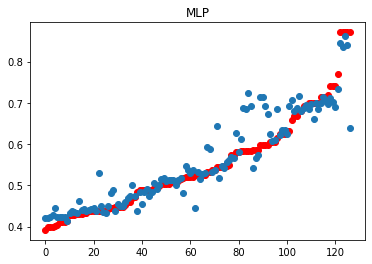

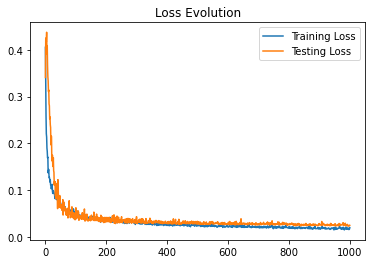

In [19]:
def pred_MLP(model,X_test,Y_test) : 

    Y_pred = np.round(model.predict(X_test),decimals=3)
    Y_pred=Y_pred.reshape((Y_pred.shape[0]))
    print('Test Absolute error:',tf.keras.losses.mean_absolute_error(Y_test, Y_pred) )
    Y_data = [Y_test,Y_pred]

    Y_data = sorted(np.transpose(Y_data),key=lambda x: x[0])
    Y_data = np.transpose(Y_data)

    x_axis = np.arange(len(Y_test))
    plt.figure()
    plt.title("MLP")
    plt.scatter(x_axis,Y_data[0],c='r')
    plt.scatter(x_axis,Y_data[1])
    
pred_MLP(model, X_test, Y_test)
plt.figure()
plt.title("Loss Evolution")
plt.plot(np.arange(1000),history.history['loss'],label='Training Loss')
plt.plot(np.arange(1000),history.history['val_loss'],label='Testing Loss')
plt.legend(loc='best')

First of all, we can easily notice on the graph that the predicted results are really good, even better than the previous models. Appart from a few outliers, the only problem lies in the samples between 80 and 110 (reminder : the data is sorted on the graph), but this problem was already present with the other models (and was more problematic actually). 

A good numerical indicator is the mean absolute error. The error of the first four models was 0.044. The SVR's error was 0.048, the KNN's one at 0.028 and the Random Forest at 0.025, just like the error found here for the MLP (the error might have changed due to the training). That shows that the results of the MLP should be equally good to the result of the Random Forest, even though it seems graphically that the MLP looks better. This is quite normal as MLPs usually can give better results than the other techniques. However, one of the most important issue of MLPs is that they are quite difficult to interpret, and thus the feature importance cannot be obtained.

We will now pass to the other regression problem.

### Median Value of Homes Regression

We will follow the same process we used for the NOX feature. Here, we are looking at the median value of owner-occupied homes in 1000's dollars, going from 5 to 50. Let's begin with our first 4 models :

##### OLS #####
Score :  0.6216630102456091
Score 2 :  3.6828753424148433
##### Ridge #####
{'alpha': 1.151395399326447}
Score :  0.6071443685352141
Score 2 :  3.694880978128684
##### Lasso #####
{'alpha': 0.012648552168552958}
Score :  0.6175834818679795
Score 2 :  3.6800734322898636
##### ElasticNet #####
{'alpha': 0.0030888435964774815, 'l1_ratio': 0.001}
Score :  0.6068938427262753
Score 2 :  3.6954498349604985


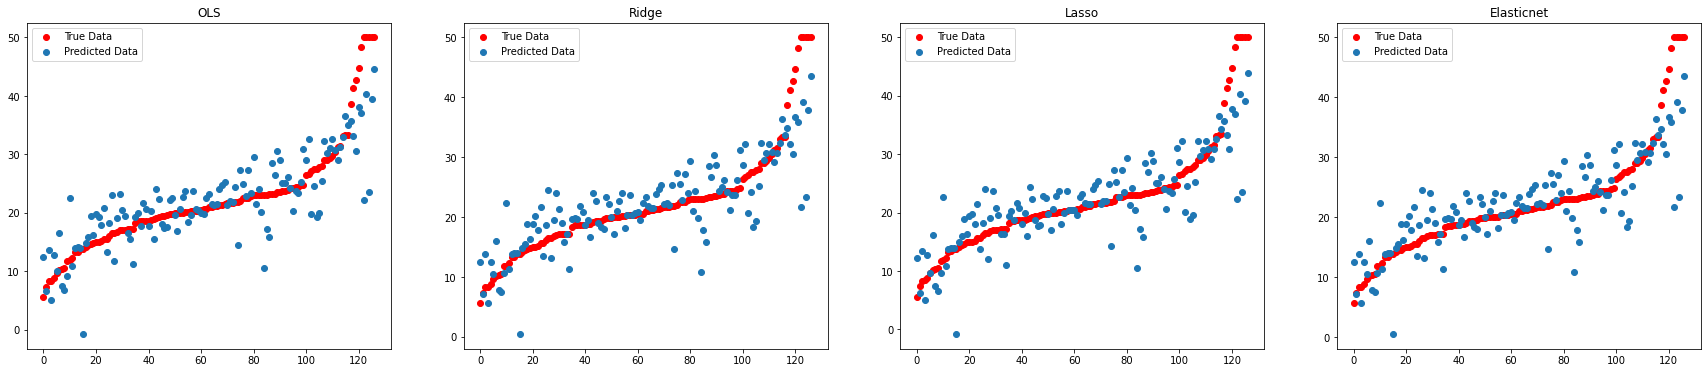

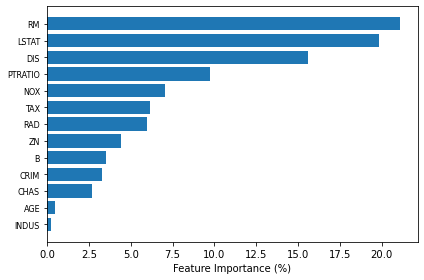

In [20]:
X,Y,X_train,X_test,Y_train,Y_test=create_XY('MEDV')
## Normalization
norm = MinMaxScaler()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

ols_ridge_lasso(X_train,Y_train,X_test,Y_test)
ols_feature_importance(X_train,Y_train)


First of all, we can notice that this feature seems to be more difficult to predict than the NOX feature. Indeed, these simple models have approximatively an accuracy of 0.6, while the accuracy for the previous feature was of 0.73.

Moreover, because the values of the median values of homes go from 5 to 50, while the median values of NOX go from 0.38 to 0.87, the loss will always be way higher for this new feature (except if we find an excellent model, but the above predictions make this hypothesis unlikely).

However, we can make similar remarks on these results. For instance, while the predicted data is almost always close to the true values, it is also almost never precisely the good value. Moreover, we can notice some patterns on the four graphs of predicted data, these four models predict the values in a similar fashion.

Now let's concentrate on the feature importance, which, obviously, is quite different than the NOX's one. Firstly, the number of room by dwellings is the most important feature and this is totally normal, as this will directly influence the price of the house. In contrary to the NOX feature importance, most of the features can be linked to the houses' values. For instance, the distance to employment centers is also clearly important as people will want to live neir their workplace. 

However, some of the features have unexpected low importance while others have unexpected high importance. We could have thought being next to the Charles river would bring an increase on the houses' values, but its importance is only of 2.5% (the probable reason will be explained later). On the contrary, we wouldn't have thought that the pollution's levels would be the fifth criterion to decide where to live (especially when we are only looking at Boston and its neighborhood).

It is however important to keep in mind, that the OLS model was far from being perfect, and, just like for the pupil teacher ratio for the NOX feature, the feature importances might change with better models.

Let's look at other models :

##### KNN #####
{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Score :  0.6268345394667995
Score 2 :  3.364825775123998
##### SVR #####
{'C': 100, 'gamma': 1}
Score :  0.7694693784925277
Score 2 :  2.6289558984528063
##### Random Forest #####
{'n_estimators': 112}
Score :  0.7493476510295443
Score 2 :  2.70945233408324


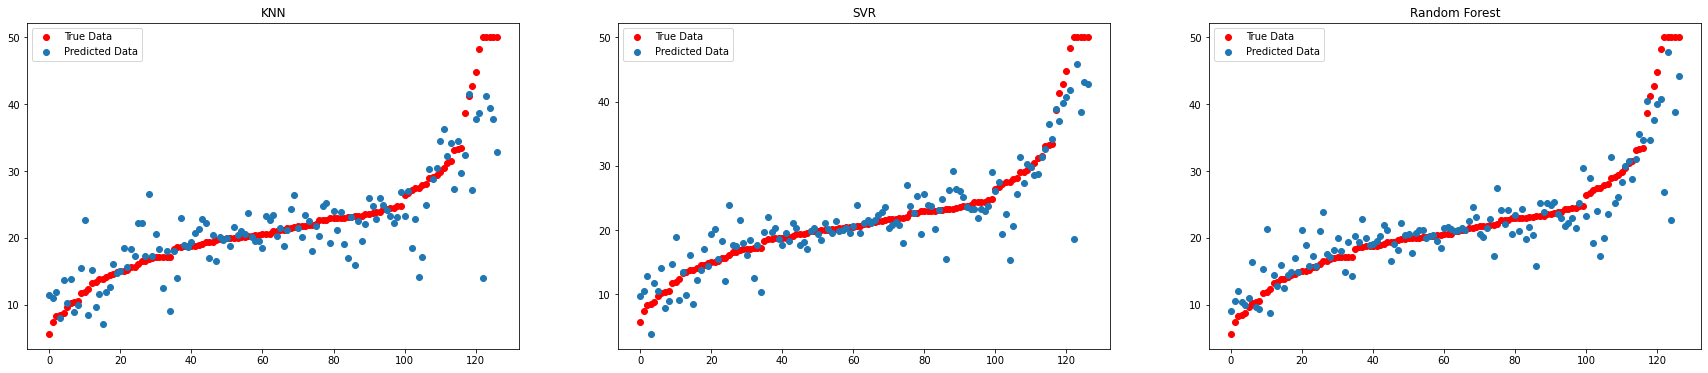

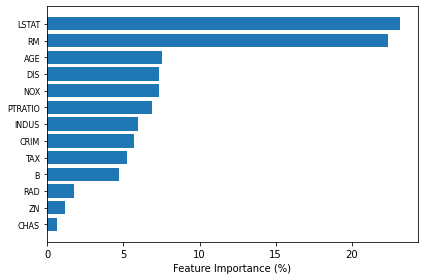

In [21]:
knn_svr_randforest(X_train,Y_train,X_test,Y_test)
random_forest_importance(X_train,Y_train)

For the MEDV feature, the KNN algorithm gives disappointing results quite similar to the results we previously obtained (in terms of scores). However, the support vector regressor and the random forest gave better results, with an increasing in accuracy of 0.15 compared to the four previous models. While this increase is really good, it seems that the difficulty of this prototask is higher than the first one and that attaining an accuracy of 0.88 will most likely not be possible.

However, just like for the NOX feature, apart from some outliers, the results are way more precise and close to the data than the other models. We can also notice that the random forest agorithm can even predict a bit of the higher values that no other algorithms succeeded in doing.

We can now talk about the feature importance. While the three first features didn't change their order, the rest had a lot of changement. Firstly, it is important to notice that the number of room per dwelling and the proportion of lower status population became way more important than the other features with approximatively 23% each while the other features have an average of 4%. Hence, apart from these two features, the order of the rest doesn't matter much, as they all have quite equivalent small values (except for the presence of highways, the presence of the river, and the proportion of residential zones). The kind of equity between these features makes sense actually as the values will depend on each of these features to be computed in real life.

Finally, it's interesting to notice that the Charles River variable is even less important than before, which can seem a bit strange as houses with the river's view should have a higher value ; however, most of the houses of each sample bounded by the river do no have anything to do with the river actually.

Let's now try to find an even better model by using a neural network.

Test Absolute error: tf.Tensor(2.690866, shape=(), dtype=float32)


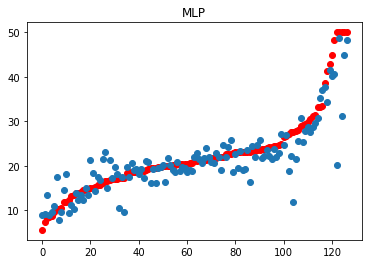

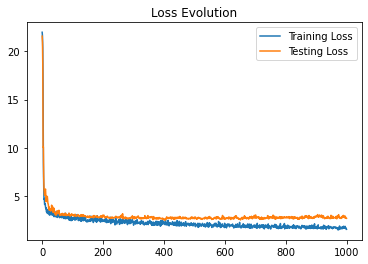

In [22]:
history = model.fit(x=X_train, y=Y_train, batch_size=40, epochs=1000,verbose=0,validation_data=(X_test, Y_test)) 

pred_MLP(model,X_test,Y_test)
plt.figure()
plt.title("Loss Evolution")
plt.plot(np.arange(1000),history.history['loss'],label='Training Loss')
plt.plot(np.arange(1000),history.history['val_loss'],label='Testing Loss')
plt.legend(loc='best')

We can notice with the graph that the results seems at least better than some of the models. Once again, the predictions are not perfect. However, the results are still quite good actually. If we remove the few important outliers, the results become very good as, apart from these outliers, the model is really precise.

We note that the final testing error is of 2.69, which is equivalent to the result found in our best algorithms : the SVR and the random forest (2.69 is between these two's errors). The loss evolution also shows us that the testing loss seems to have attained its minimum, as, while the training loss was slowly decreasing between 600 and 1000 epochs, the testing loss was kind of constant.

### Conclusion


We've seen that the two features representing the pollution (NOX) and the median houses' values (MEDV) could be relatively well predicted and modelled with accuracy close to 0.9 and 0.77 respectively. While the houses' values were more difficult to predict, the models were still quite satisfying, with only a few outliers that would increase greatly the loss. 

As we could have guessed, for both prototasks, the multilayers perceptrons were considered the best models along with the random forest algorithms.

**NOX :**

Our best models seem really good with an accuracy of 0.9. However, I feel that our data was not really optimal for the regression of this feature, as features like the pupil teacher ratio or the proportion of black people are clearly not direct indicators of the pollution level. We could have probably obtained even better results with features oriented towards pollution-making objects and deeds. Also, our final best error was still 0.025 of nitric oxydes concentration, which is clearly quite high compared to a direct measurement (as the minimal values were 0.38, hence a percentage of 6.5%). 


**MEDV :**

While this model seems reasonable for the given data, I wouldn't use it for predicting houses' values in real life, for a few reasons. First of all, every sample represents a set of houses, hence we are not working on separated housed, and using average and medians might have brought outliers and issues. Moreover, while our results can be considered relatively good, our error still was 2.69, which represent more than one half of the less expensive houses ! That means that for the less expensive houses, the error is clearly not negligeable. Finally, some of the outliers found in the graphs have really important errors (the most critic one is a prediction of 20 for a true value of 50 approximately...).